# In this notebook I develop several heuristics for rating the quality of the shots.

In [1]:
import numpy as np
import sqlite3
import MDSplus as mds
import scipy.fftpack as fft

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

# Bias current heuristics

I want to determine:
1. the peak current
2. the crowbar time
3. the noise in the pre-ramp phase of the signal 

In [3]:
connection = sqlite3.connect('shots.db')
connection.row_factory = sqlite3.Row
cursor = connection.cursor()
cursor.execute("SELECT * FROM Shots")
rows = cursor.fetchall()
cursor.close()
connection.close()
first_shot = rows[0]

In [6]:
tree = mds.Tree('rsx', shot['shot'])
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3


## Typical bias current trace

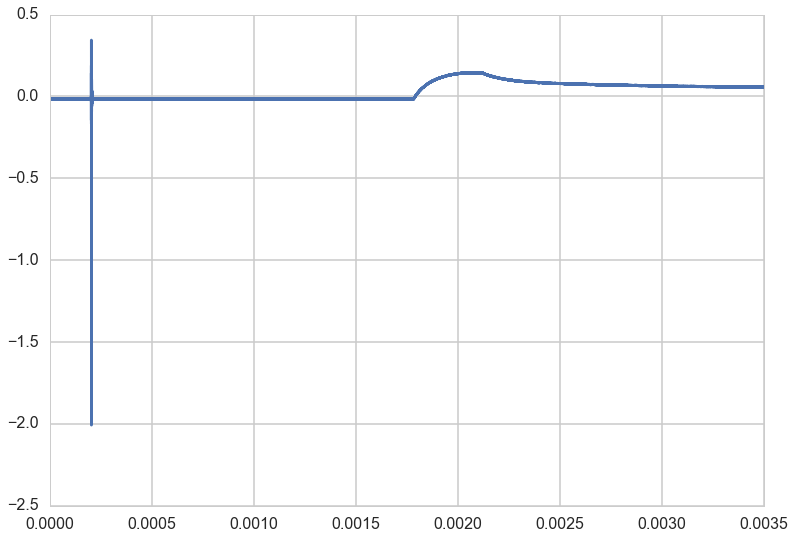

In [7]:
plt.plot(bias_current_time, bias_current)

### Typical bias current noise. I can take the standard devation as a measure of the noise

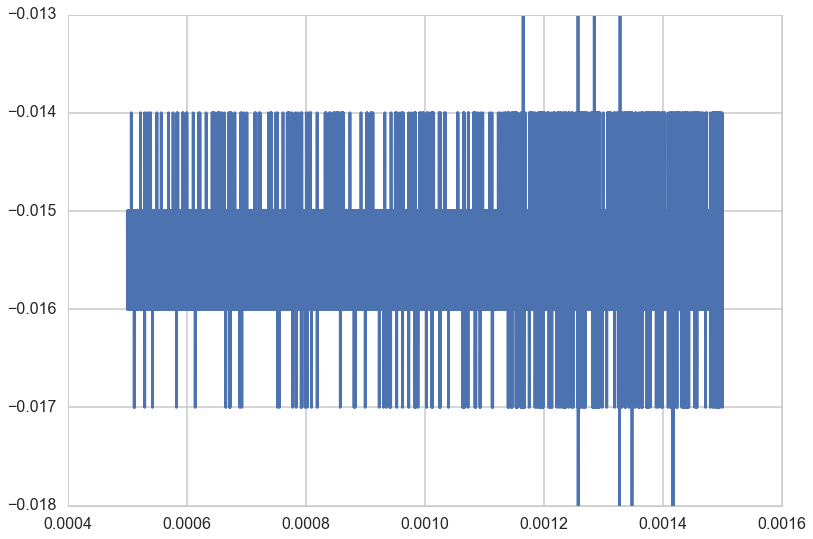

In [11]:
plt.plot(bias_current_time[10000:30000], bias_current[10000:30000])

## Determine peak current

To determine the peak current I smooth the bias current trace with a boxcar filter and take the max.
The choice of baxcar width is important I don't want it to be too wide, since that reduces the peak but also not to short since then noise could be misinterperted as the peak.

In [13]:
tree = mds.Tree('rsx', 15409)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

39991 40000 39991
39991 40000


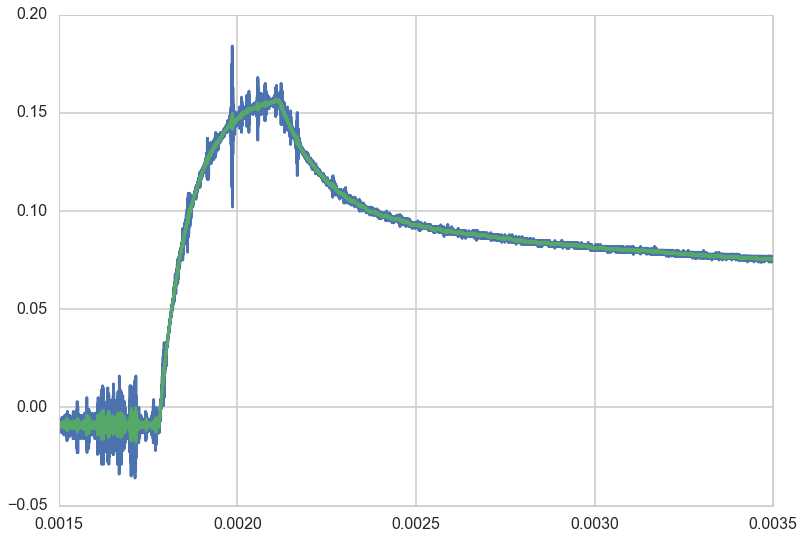

In [512]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 10
w = np.ones(window_len,'d')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='valid')
print y.size, signal_to_filter.size, time_to_filter[4:-5].size
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter[4:-5], y)
print y.size, signal_to_filter.size

### N.B. This is a noiser shot the pre-ramp phase has a higher standard deviation.

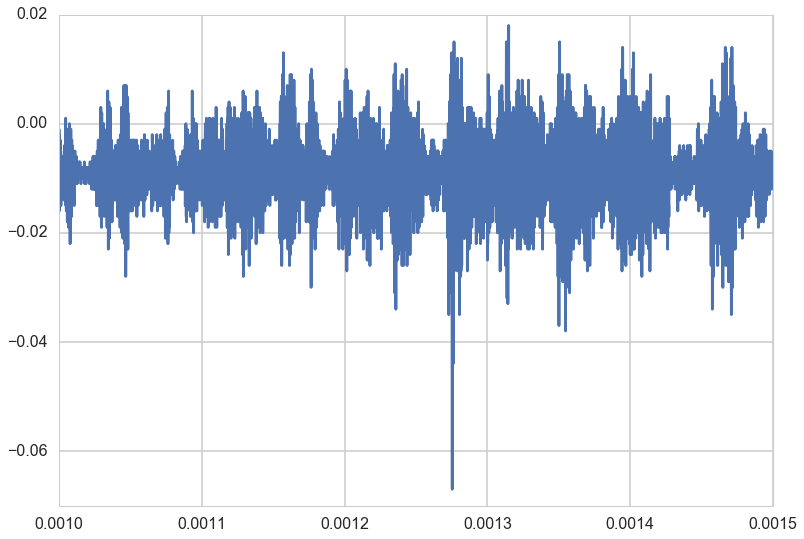

In [15]:
plt.plot(bias_current_time[20000:30000], bias_current[20000:30000])

In [513]:
tree = mds.Tree('rsx', 15416)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

39991 40000 39991
39991 40000


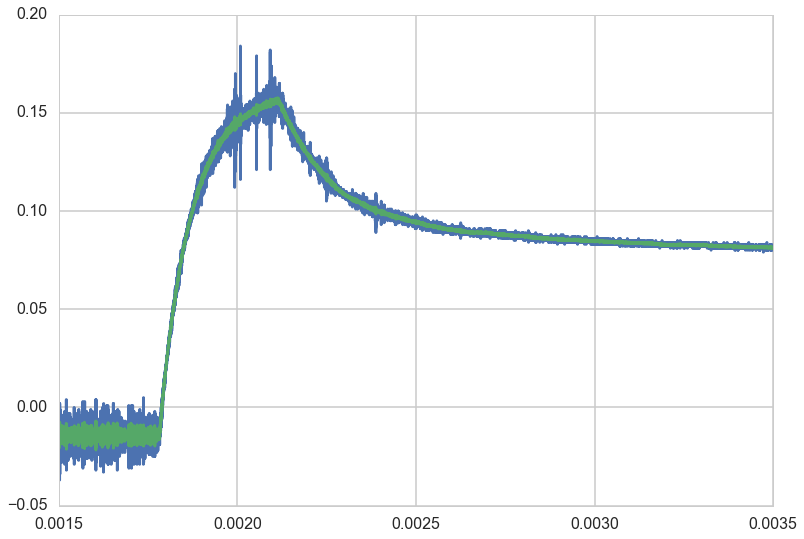

In [518]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 10
w = np.ones(window_len, 'd')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='valid')
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter[4:-5], y)


In [519]:
tree = mds.Tree('rsx', 15420)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

39251 40000 39251
39251 40000


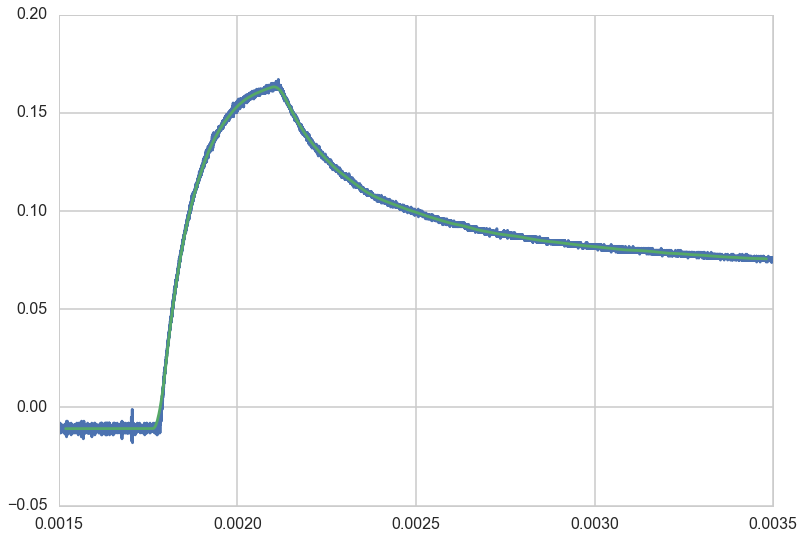

In [520]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 750
w = np.ones(window_len,'d')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='valid')
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter[374:-375], y)

## To identify the crowbar time I want to look at the zerocrossing of the derivative. I use a much stronger filter to make the derivatives smooth, since differentiating amplifies noise.

40000 40000 39251
40000 40000


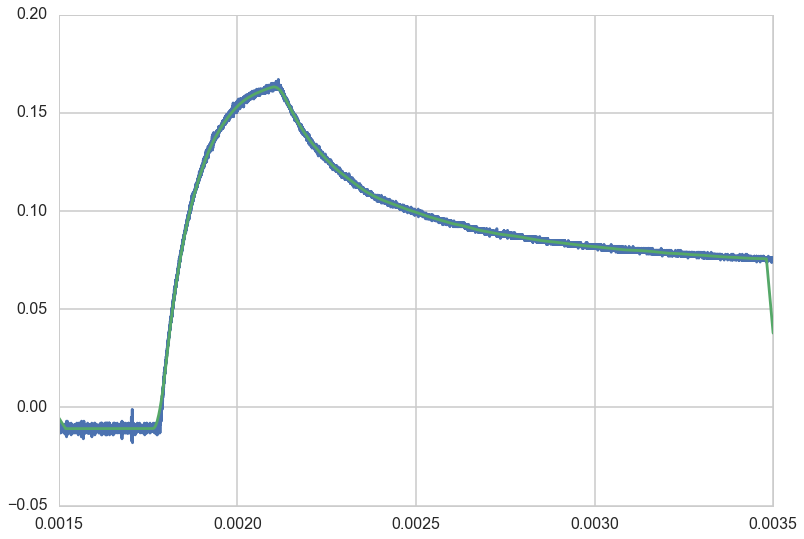

In [522]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 750
w = np.ones(window_len,'d')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='same')
print y.size, signal_to_filter.size, time_to_filter[374:-375].size
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter, y)
print y.size, signal_to_filter.size

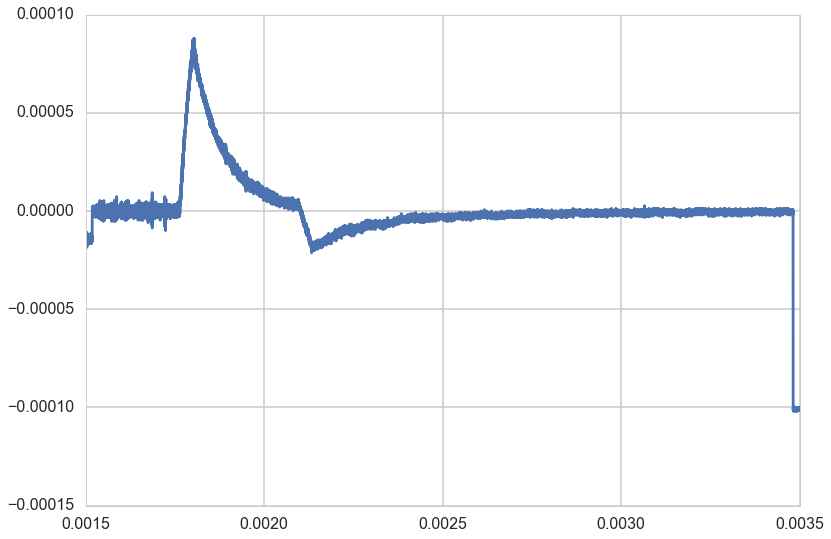

In [524]:
plt.plot(time_to_filter, np.gradient(y))

### I add a small offset to the derivative to make it easier to differentiate the zero-crossing from samller ones induced by noise 

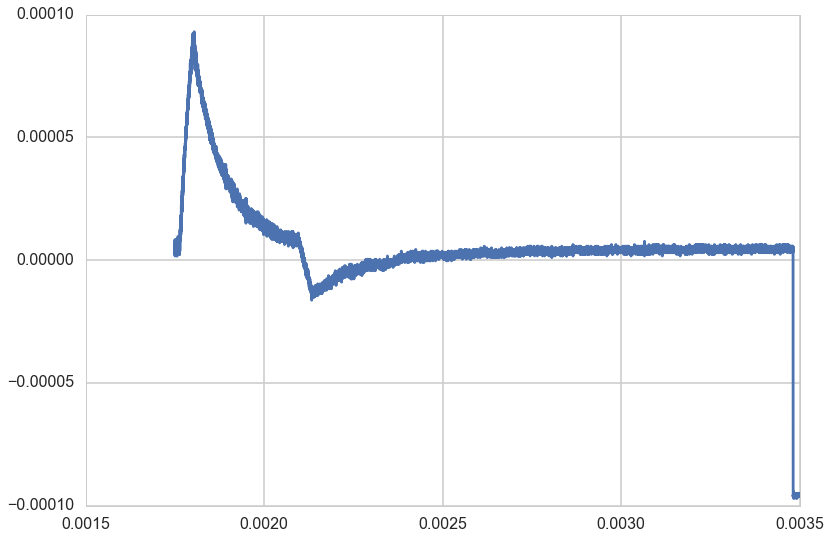

In [526]:
plt.plot(time_to_filter[5000:], np.gradient(y)[5000:]+0.000005)

In [378]:
np.where(np.diff(np.sign(np.gradient(y[6000:]+0.000005))))[0]

array([ 5629,  5630,  5631, ..., 33243, 33244, 33246])

In [380]:
time_to_filter[499:-500][6000:][5629]

0.0021064002

# Develop gyration heursitics

## Plan look at fft of fiducial, record signal strength, and time window at which frequency starts

### First what is the distribution of periods determined by Jason's Script

In [17]:
connection = sqlite3.connect('shots.db')
cursor = connection.cursor()
cursor.execute('SELECT period FROM Shots WHERE fiducial_a_signal_exists=1 AND bias_current_signal_exists=1')
periods = cursor.fetchall()

In [18]:
cleaned_periods = []
for period in periods:
    if period[0] == None:
        pass
    else:
        cleaned_periods.append(period[0])
cleaned_periods = np.asarray(cleaned_periods)    

In [19]:
cleaned_periods.size

2095

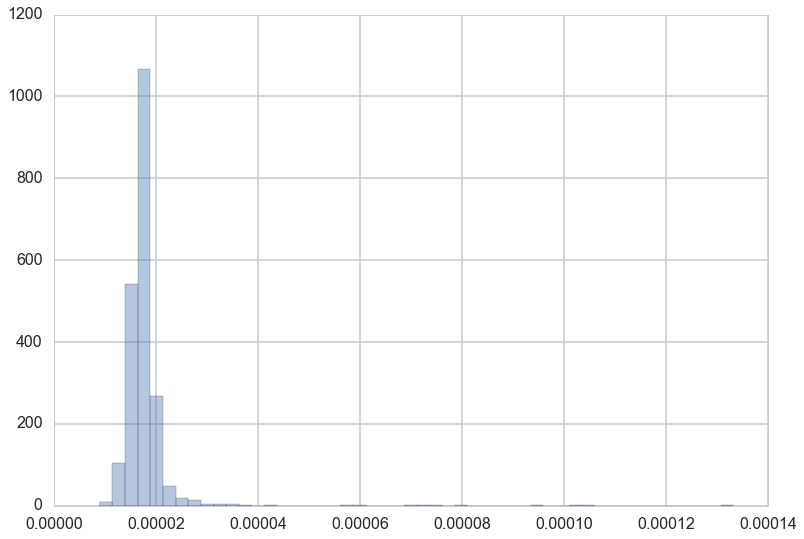

In [20]:
sns.distplot(cleaned_periods, norm_hist=False, kde=False)

In [21]:
cleaned_periods.mean()

1.7753055709056326e-05

In [22]:
cleaned_periods.std()

5.5611730431042248e-06

### Distrbution of Frequencies

The distribution is approximatly Gaussian with a small bump.

In [23]:
cleaned_frequencies = 1/cleaned_periods

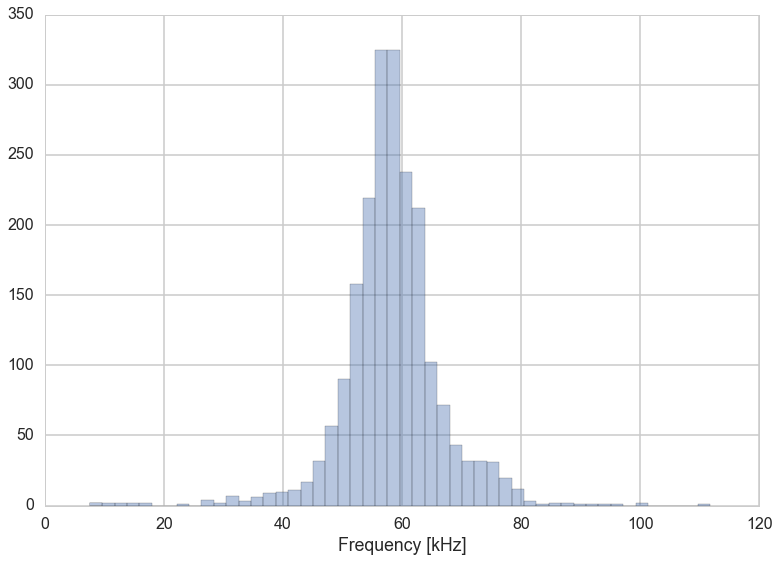

In [35]:
sns.distplot(cleaned_frequencies/1000, norm_hist=False, kde=False, axlabel='Frequency [kHz]')

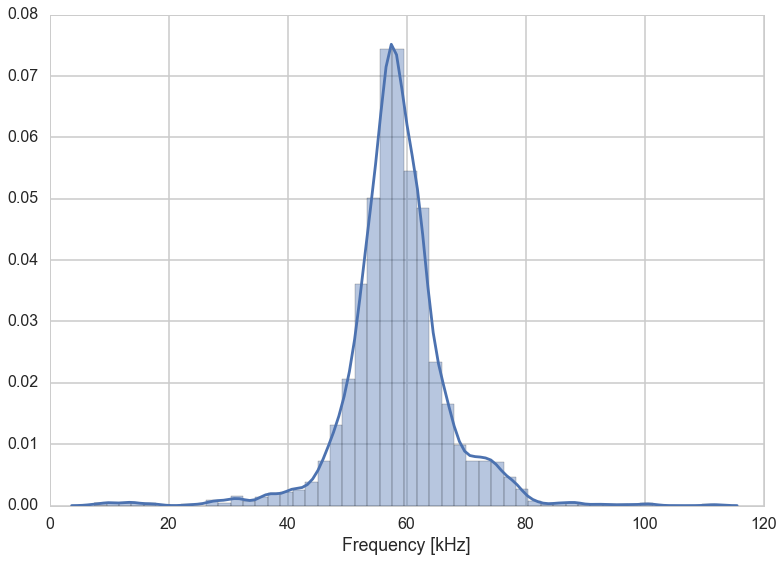

In [36]:
sns.distplot(cleaned_frequencies/1000, norm_hist=False, axlabel='Frequency [kHz]')

In [456]:
cleaned_frequencies.mean()

58254.056383850373

In [28]:
cleaned_frequencies.std(ddof=1)

8388.436120787459

### The gryration frquency over the 3000 shots is $f=58kHz \pm 8kHz$

In [244]:
print "The mean oscillation frequency is %(freq)5.2e" % {'freq': 1/cleaned_periods.mean()}

The mean oscillation frequency is 5.63e+04


In [232]:
print ("68 percent of the frequency measuremnts lie between %(low)5.2e and %(high)5.2e" % 
       {'low': 1/(cleaned_periods.mean() - cleaned_periods.std()),
        'high': 1/(cleaned_periods.mean() + cleaned_periods.std())})

68 percent of the frequency measuremnts lie between 8.20e+04 and 4.29e+04


## Let's look at the frequency spectrum of a shot with gyration (15432) and one without (15557)

In [54]:
tree = mds.Tree('rsx', 15423)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_with_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3

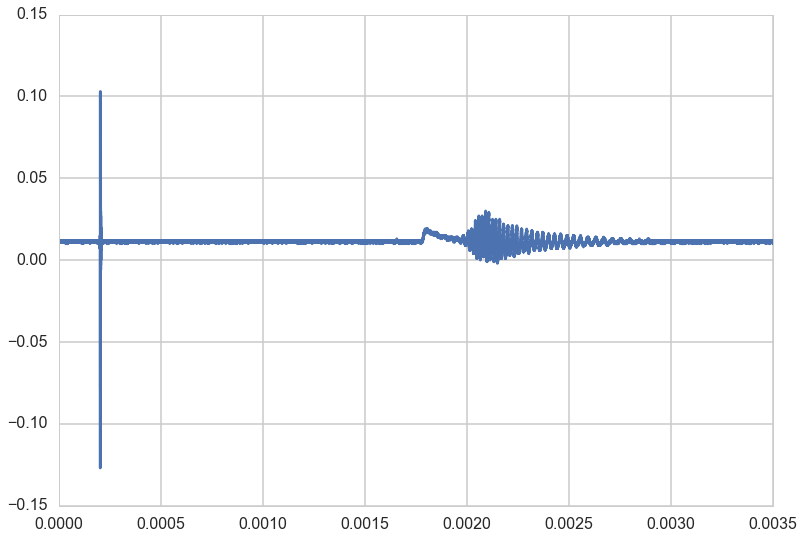

In [55]:
plt.plot(fiducial_time, fiducial_with_oscillation)

## Taking a fft of the whole signal the peak around 56kHz in spectrum is noticeable

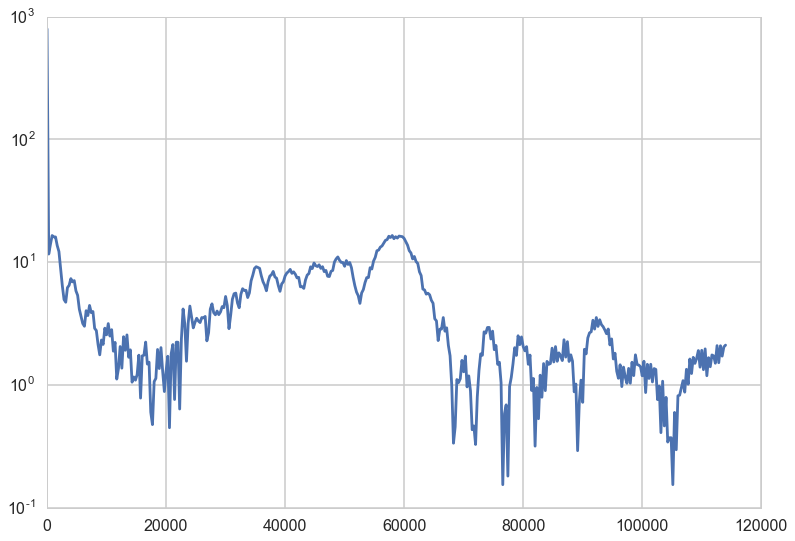

In [56]:
size = fiducial_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+400], np.abs(fft.fftshift(fft.fft(fiducial_with_oscillation))[midpoint:midpoint+400]))


## Does the gyration peak become more pronounced if we only look at the time window after the current ramps up

In [57]:
from scipy.signal import blackman

In [58]:
window_with_oscillation = fiducial_with_oscillation[35500:60000]

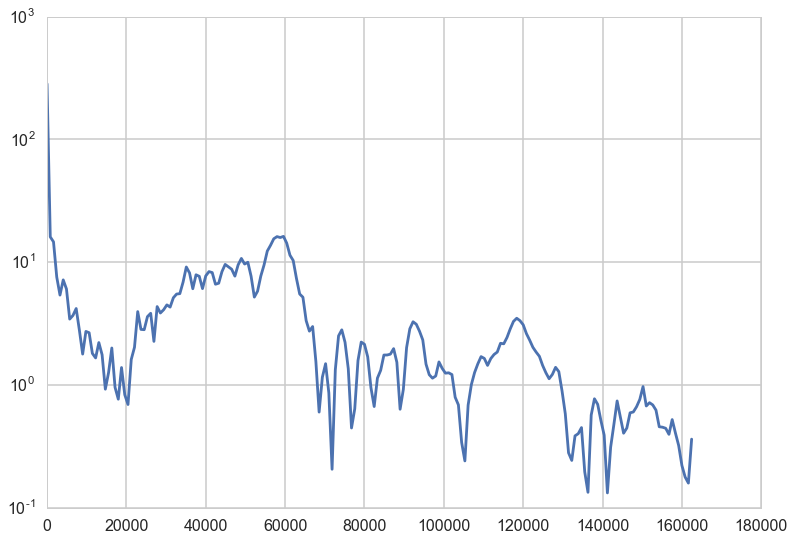

In [59]:
size = window_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+200], np.abs(fft.fftshift(fft.fft(window_with_oscillation))[midpoint:midpoint+200]))

## Let's see if multiplying by a window function helps remove some other frequencies which might be due to edge effects.

In [62]:
windowed = blackman(40000)*fiducial_with_oscillation[20000:60000]
#windowed = fiducial[30000:60000]
#windowed = np.pad(windowed, 100000, mode='symmetric')

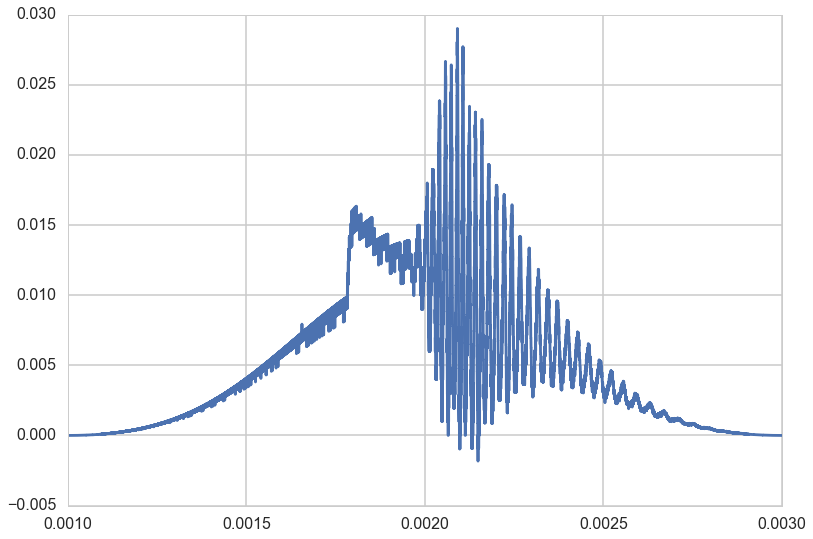

In [63]:
plt.plot(fiducial_time[20000:60000], windowed)

### The spectrum is not much clearer I will not use a window function

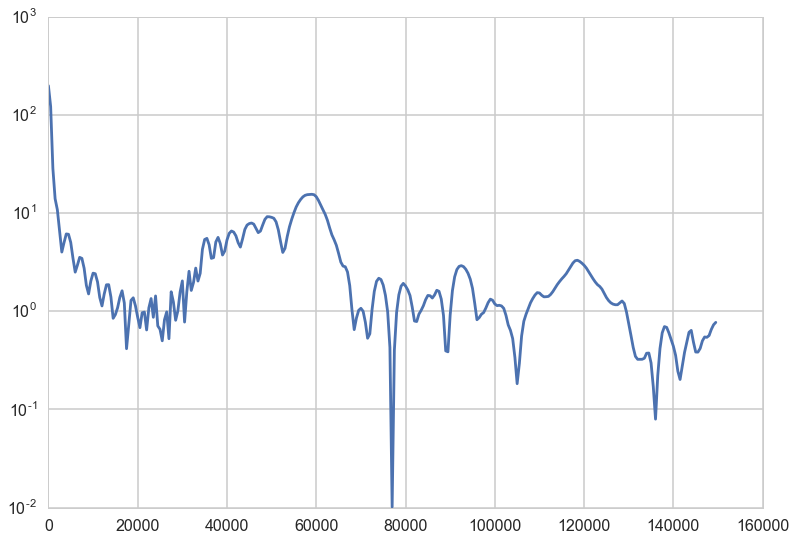

In [64]:
size = windowed.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+300], np.abs(fft.fftshift(fft.fft(windowed))[midpoint:midpoint+300]))

## Let's look at a shot without gyration or only a weak gyration

In [65]:
tree = mds.Tree('rsx', 15557)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_wo_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3

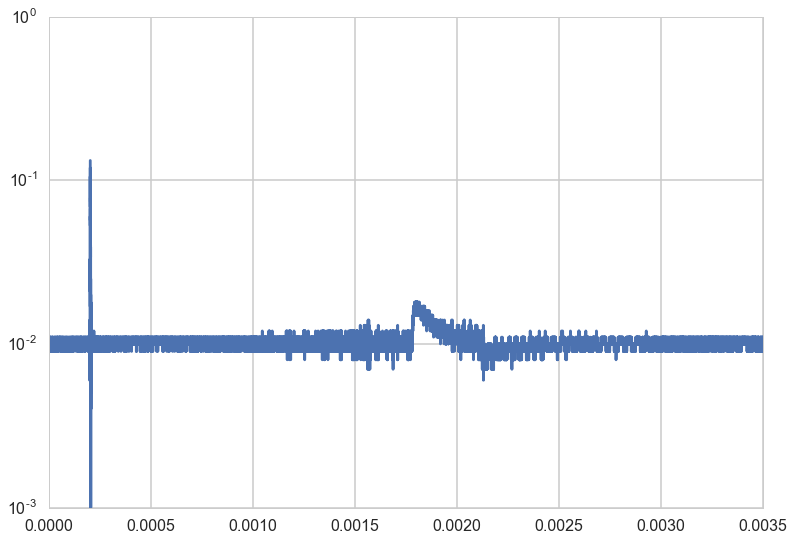

In [66]:
plt.semilogy(fiducial_time, fiducial_wo_oscillation)

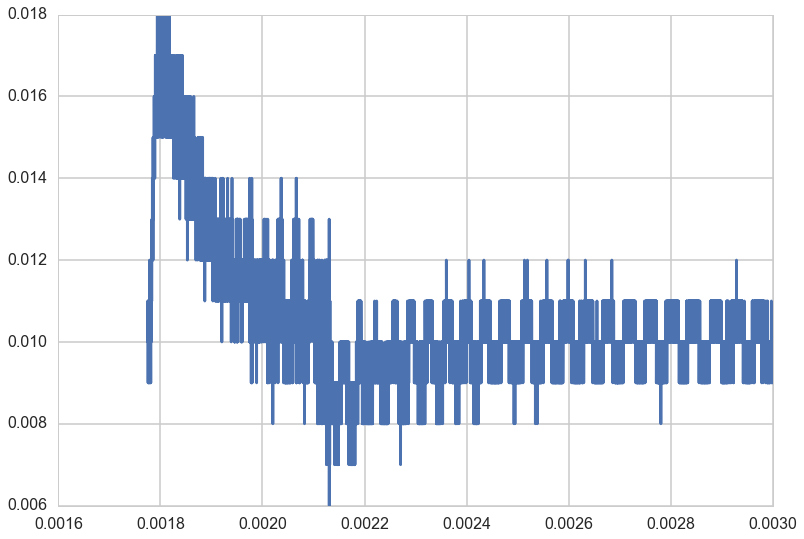

In [67]:
window_wo_oscillation = fiducial_wo_oscillation[35500:60000]
plt.plot(fiducial_time[35500:60000], window_wo_oscillation)

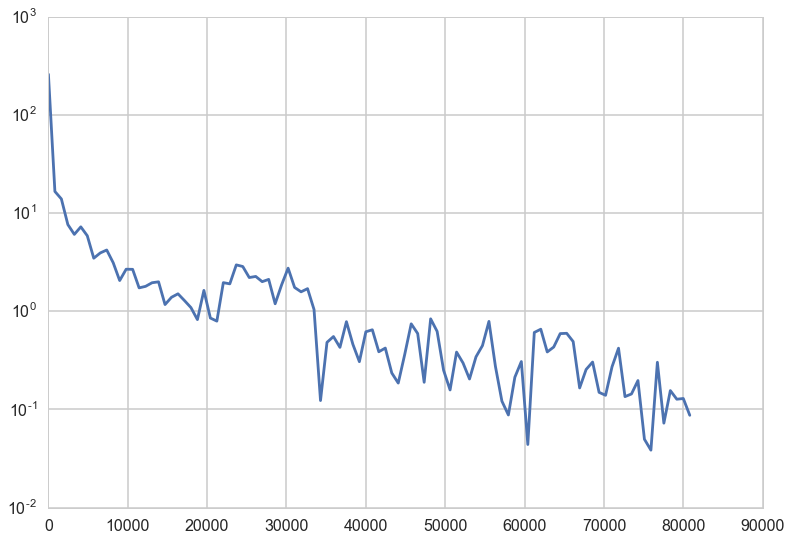

In [68]:
size = window_wo_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_wo_oscillation))[midpoint:midpoint+100]))

## Good, there is an order of magnitude difference in spectrum of shots which gyrate and those that don't

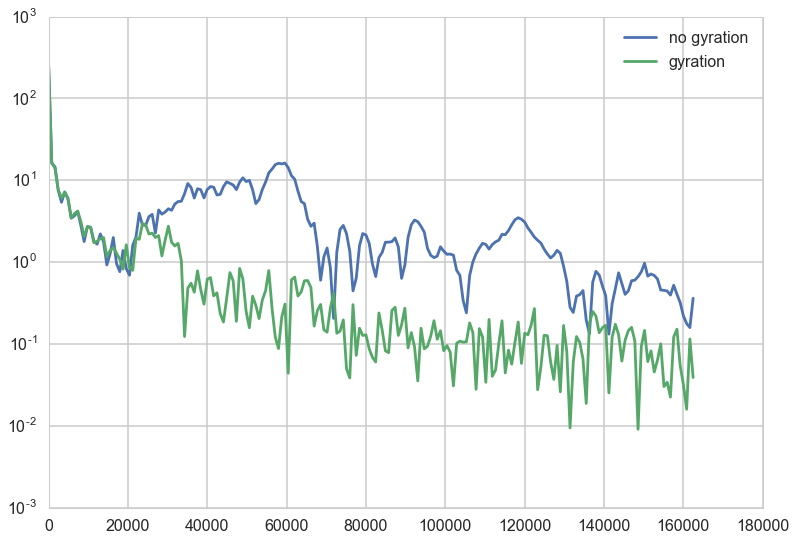

In [69]:
size = window_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+200], np.abs(fft.fftshift(fft.fft(window_with_oscillation))[midpoint:midpoint+200]), label='no gyration')
plt.semilogy(freqs[midpoint:midpoint+200], np.abs(fft.fftshift(fft.fft(window_wo_oscillation))[midpoint:midpoint+200]), label='gyration')
plt.legend()

## Now let's see if we can detect if there is an oscillation before the crowbar. The pre-crowbar most reproducible part of the shot. We want to assemble measurements from shots that gyrated before the crowbar.

## Shot 16670 has inly 3 periods before crowbar, Shot 17300 has many, Shot 15557 none 

### First look at crowbar time

0.002115


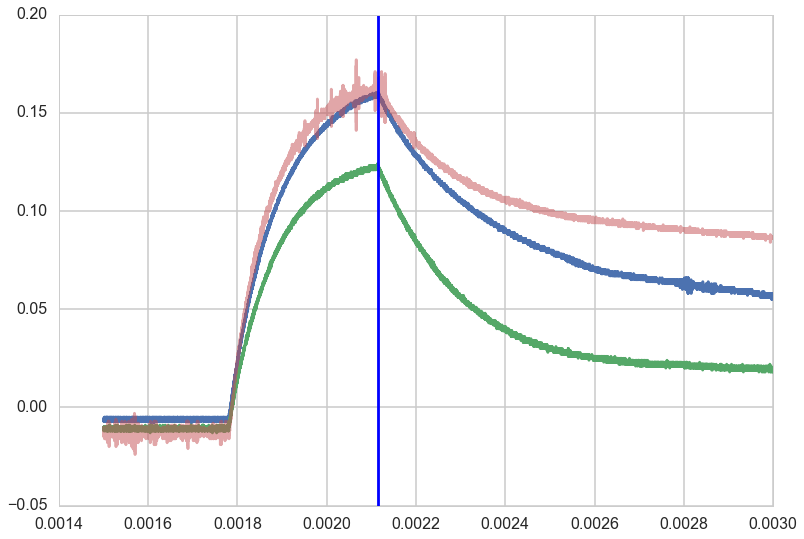

In [327]:
tree = mds.Tree('rsx', 16670)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current_short_oscillation = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

tree = mds.Tree('rsx', 17300)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current_long_oscillation = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

tree = mds.Tree('rsx', 15557)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current_no_oscillation = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

time_slice = slice(30000, 60000)
plt.plot(bias_current_time[time_slice], bias_current_short_oscillation[time_slice])
plt.plot(bias_current_time[time_slice], bias_current_long_oscillation[time_slice])
plt.plot(bias_current_time[time_slice], bias_current_no_oscillation[time_slice], alpha=0.5)
plt.axvline(0.002115)

print bias_current_time[42300]

### The crowbar time is very reproducible across shots from the whole range

### The crowbar occurs at $t=0.002115 s$ or index 42300

## Now look at the fft of windows up to index 42300

In [71]:
tree = mds.Tree('rsx', 16670)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_short_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3
tree = mds.Tree('rsx', 17300)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_long_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3
tree = mds.Tree('rsx', 15557)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_no_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3

In [72]:
window_short_oscillation = fiducial_short_oscillation[35500:42300]
window_long_oscillation = fiducial_long_oscillation[35500:42300]
window_no_oscillation = fiducial_no_oscillation[35500:42300]

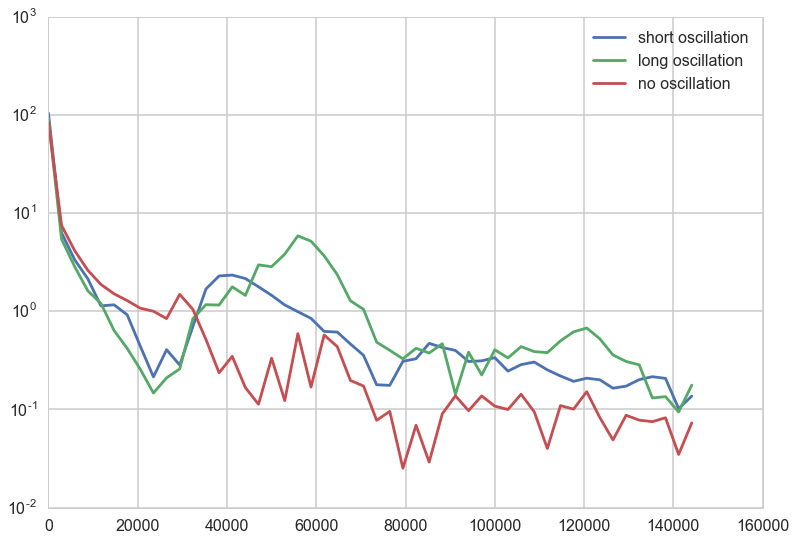

In [73]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+50], np.abs(fft.fftshift(fft.fft(window_short_oscillation))[midpoint:midpoint+50]), label='short oscillation')
plt.semilogy(freqs[midpoint:midpoint+50], np.abs(fft.fftshift(fft.fft(window_long_oscillation))[midpoint:midpoint+50]), label='long oscillation')
plt.semilogy(freqs[midpoint:midpoint+50], np.abs(fft.fftshift(fft.fft(window_no_oscillation))[midpoint:midpoint+50]), label='no oscillation')
plt.legend()

In [74]:
window_short_oscillation = fiducial_short_oscillation[25500:42300]
window_long_oscillation = fiducial_long_oscillation[25500:42300]
window_no_oscillation = fiducial_no_oscillation[25500:42300]

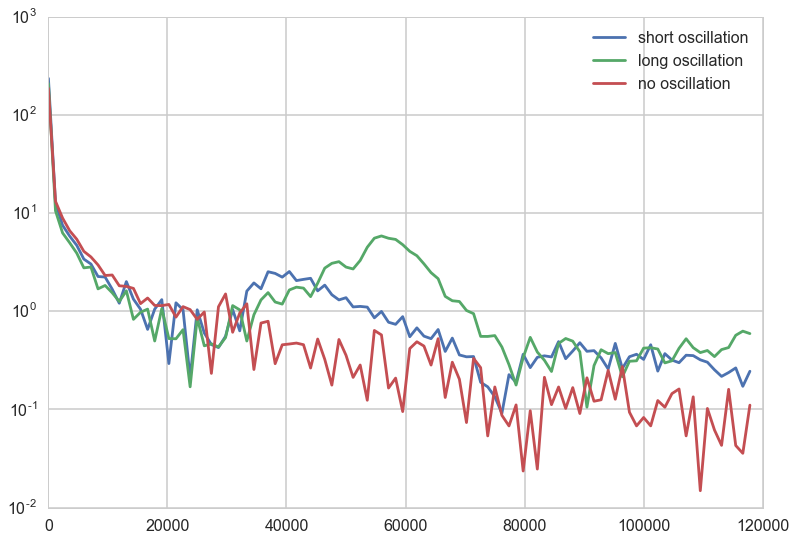

In [75]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_short_oscillation))[midpoint:midpoint+100]), label='short oscillation')
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_long_oscillation))[midpoint:midpoint+100]), label='long oscillation')
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_no_oscillation))[midpoint:midpoint+100]), label='no oscillation')
plt.legend()

In [390]:
1/0.00002195

45558.08656036446

## To get a quantitive measure we integrate the spectral power for two standard deviations of period measurements around the gyration period

In [108]:
connection = sqlite3.connect('shots.db')
connection.row_factory = sqlite3.Row
cursor = connection.cursor()
cursor.execute('SELECT shot, period FROM Shots WHERE shot=15557 OR shot=16670 OR shot=17300')
shots = cursor.fetchall()

periods = np.zeros(3)
for shot in shots:
    if shot['shot'] == 15557:
        index = 0
    if shot['shot'] == 16670:
        index = 1
    if shot['shot'] == 17300:
        index = 2
    periods[index] = shot['period']

In [109]:
frequencies = 1/periods

In [110]:
std = cleaned_periods.std()

In [111]:
std_frequencies = cleaned_frequencies.std()

In [112]:
std_frequencies

8386.4338684326958

In [113]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))

range_no_oscillation = np.where(np.logical_and(frequencies[0] - std_frequencies <= freqs, freqs <= frequencies[0] + std_frequencies))
range_short_oscillation = np.where(np.logical_and(frequencies[1] - std_frequencies <= freqs, freqs <= frequencies[1] + std_frequencies))
range_long_oscillation = np.where(np.logical_and(frequencies[2] - std_frequencies < freqs, freqs <= frequencies[2] + std_frequencies))

In [114]:
freqs[range_no_oscillation]

array([ 36904.76147349,  38095.23765005,  39285.71382662,  40476.19000318,
        41666.66617975,  42857.14235631,  44047.61853287,  45238.09470944,
        46428.570886  ,  47619.04706257,  48809.52323913,  49999.9994157 ,
        51190.47559226,  52380.95176882])

## There are clear differences in the integrated areas below the curves for the different classes of shots.

### N.B. the period determined in Jason's script does not correspond to the middle of the spectral peak. This might be because the oscillation is not truely sinsoidal, i.e. is made of a smear of frequencies and the gryration period varies over time

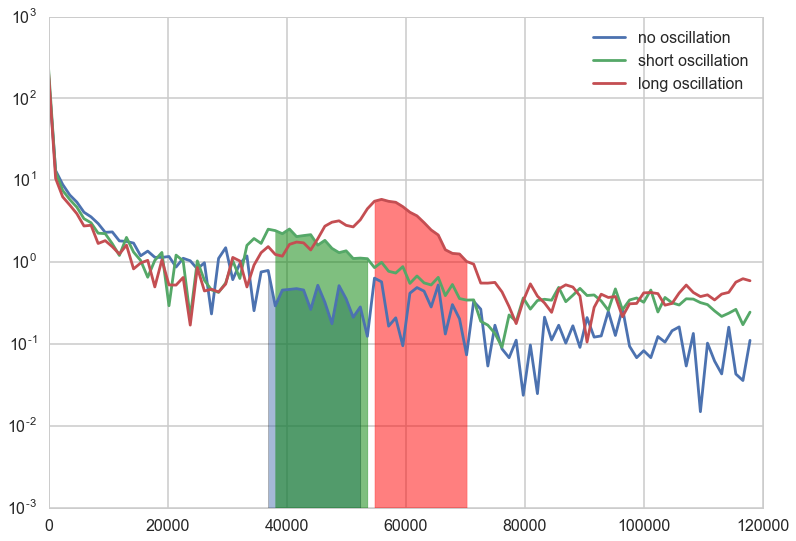

In [115]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2

no_oscillation_fft = np.abs(fft.fftshift(fft.fft(window_no_oscillation)))
short_oscillation_fft = np.abs(fft.fftshift(fft.fft(window_short_oscillation)))
long_oscillation_fft = np.abs(fft.fftshift(fft.fft(window_long_oscillation)))

plt.semilogy(freqs[midpoint:midpoint+100], no_oscillation_fft[midpoint:midpoint+100], label='no oscillation')
plt.fill_between(freqs[range_no_oscillation], no_oscillation_fft[range_no_oscillation], 1e-3, alpha=0.5)
plt.semilogy(freqs[midpoint:midpoint+100], short_oscillation_fft[midpoint:midpoint+100], label='short oscillation')
plt.fill_between(freqs[range_short_oscillation], short_oscillation_fft[range_short_oscillation], 1e-3, alpha=0.5, color='g')
plt.semilogy(freqs[midpoint:midpoint+100], long_oscillation_fft[midpoint:midpoint+100], label='long oscillation')
plt.fill_between(freqs[range_long_oscillation], long_oscillation_fft[range_long_oscillation], 1e-3, alpha=0.5, color='r')
plt.legend()

In [98]:
from scipy.integrate import cumtrapz

### Integrated spectral power

In [99]:
cumtrapz(no_oscillation_fft[range_no_oscillation], freqs[range_no_oscillation])[0]

50.243929860491868

In [100]:
cumtrapz(short_oscillation_fft[range_short_oscillation], freqs[range_short_oscillation])[0]

57.737958785376989

In [101]:
cumtrapz(long_oscillation_fft[range_long_oscillation], freqs[range_long_oscillation])[0]

73.825691274315986

## The units are bit meaning less. For one the spectral density depends on the arbritaritly choosen lenght of the time window. Also I have to look up how the amplitude of fourier transform relates to power.

In [102]:
import scipy.signal

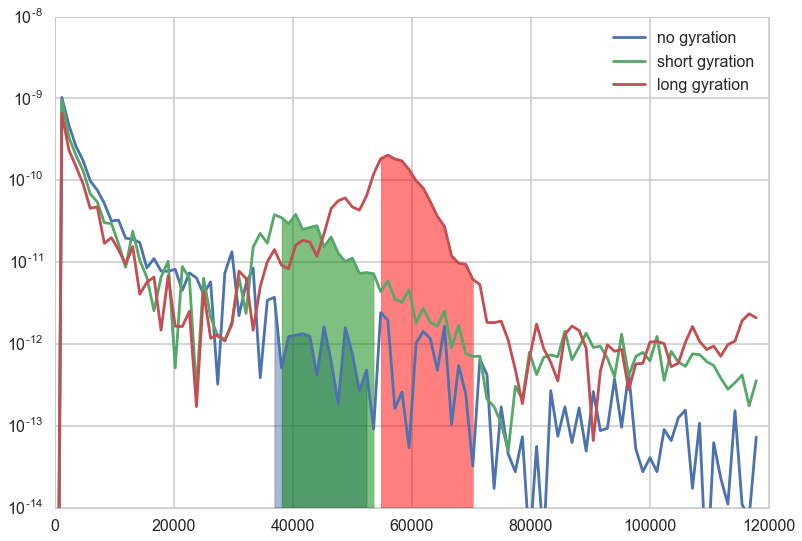

In [103]:
fs = 1/(fiducial_time[1] - fiducial_time[0])

freqs, no_oscillation_fft = scipy.signal.periodogram(window_no_oscillation, fs)
freqs, short_oscillation_fft = scipy.signal.periodogram(window_short_oscillation, fs)
freqs, long_oscillation_fft = scipy.signal.periodogram(window_long_oscillation, fs)

range_no_oscillation = np.where(np.logical_and(frequencies[0] - std_frequencies <= freqs, freqs <= frequencies[0] + std_frequencies))
range_short_oscillation = np.where(np.logical_and(frequencies[1] - std_frequencies <= freqs, freqs <= frequencies[1] + std_frequencies))
range_long_oscillation = np.where(np.logical_and(frequencies[2] - std_frequencies < freqs, freqs <= frequencies[2] + std_frequencies))

plt.semilogy(freqs[:100], no_oscillation_fft[:100], label='no gyration')
plt.semilogy(freqs[:100], short_oscillation_fft[:100], label='short gyration')
plt.semilogy(freqs[:100], long_oscillation_fft[:100], label='long gyration')
plt.fill_between(freqs[range_no_oscillation], no_oscillation_fft[range_no_oscillation], 1e-14, alpha=0.5)
#plt.semilogy(freqs[midpoint:midpoint+100], short_oscillation_fft[midpoint:midpoint+100], label='short oscillation')
plt.fill_between(freqs[range_short_oscillation], short_oscillation_fft[range_short_oscillation], 1e-14, alpha=0.5, color='g')
#plt.semilogy(freqs[midpoint:midpoint+100], long_oscillation_fft[midpoint:midpoint+100], label='long oscillation')
plt.fill_between(freqs[range_long_oscillation], long_oscillation_fft[range_long_oscillation], 1e-14, alpha=0.5, color='r')
plt.legend()
plt.ylim((1e-14, 1e-8))
plt.show()

### Note order of magnitude differences in integrated spectral density

In [104]:
cumtrapz(no_oscillation_fft[range_no_oscillation], freqs[range_no_oscillation])[0]

2.5096794079060299e-09

In [105]:
cumtrapz(short_oscillation_fft[range_short_oscillation], freqs[range_short_oscillation])[0]

3.8303441485162321e-08

In [106]:
cumtrapz(long_oscillation_fft[range_long_oscillation], freqs[range_long_oscillation])[0]

2.2937349502820847e-07